# **Credence** - Evaluating Causal Inference Methods

*Premise*: Retrospective causal inference methods are widely used to estimate the impact of an intervention where randomized controlled trials are not an option for example, fee changes or marketing campaigns. The main challenge in retrospective and non-experimental causal inference is that we only observe the outcome under one of the treatment choices while the counterfactual is never observed. Causal inference methods aims to re-create the scenario in which the alternative treatment was chosen i.e. estimating the counterfactual. 

*Background*: Traditional causal inference methods are primarily evaluated quantitatively in two ways: 1) placebo tests and 2) tests on simulated data. Placebo tests check that the treatment effect estimated by a particular method is zero during a period there is actually no intervention: in that situation, the actual should match the counterfactual. Testing on simulated data is limited because the data generative process is often simple and lacks the complexities of real world datasets where the method is actually applied. For applied researchers, the important question is understanding how well a method actually performs in realistic situations. 

*Contribution*: In this work, we propose a framework for learning the generative mechanism that generates complex and realistic samples with known treatment effects. The framework uses a black-box generator like VAE or GAN coupled with an interpretable part. The black-box model allows generation of complex data while the interpretable model allows manipulation and intervention on the samples to encode treatment effects. The generated data can be used to assess the performance of (multiple) causal estimation method(s). The performance metrics (e.g. accuracy or error-rates) are then used to choose the most appropriate causal estimation methods for a given dataset.



## Framework

![Credence Framework](../images/credenceframework.png)

Credence uses state-of-the-art deep generative models such as variational auto-encoders (VAEs) to approximate the universe of complex datasets. These generative models are trained and validated on a collection of observed data sets. Credence uses these trained deep generative models to generate data that has analogous complexity to the observed data. Credence’s procedure enables users to have perfect knowledge about  ground truth treatment effects of the intervention in the generated data. This allows the users to evaluate their method in a principled fashion without compromising on the complexity or the realness of the data they are evaluating the method on.

Credence learns a generative model by anchoring the level of endogeneity or treatment effect or anchoring both simultaneously. Anchoring the treatment effect and/or endogeneity is analogous to constraining the search space of potential data generators. Our approach can be conceptualized as projecting the true data-generative process to a constrained space of data-generators and finding the closest data-generator that conserves the joint distribution of X,Y,Z as close as possible to that of the observed data under the constraints. 

### Optimization Setup

Generalized optimization framework takes as an input the observed data that consists of pre-treatment (X) and post-treatment variables (Y) along with a binary treatment indicator (Z). Further, the framework accepts user defined treatment effect function (f) and selection-bias or confounder-bias function (g). User can also pre-specify the rigidness or strength at which they want the treatment effect and selection-bias to determined by f and g. The optimization objective aims at finding the generative model parameters such that the sum of the distance metric between the joint observed data distribution  and the joint generated data distribution along with the treatment effect constraint and selection bias constraint is minimized. For instance, the distance metric can be Wasserstein distance. The treatment effect constraint forces the condition average treatment effect to be equal to f(X) and the selection bias constraint forces the difference of potential outcome for a treatment under same and opposite treatment to be equal to g(X,Z). In case there is trade-off between minimizing each of the three objectives, the rigidness coefficient is used to prefer one over the other.

Let $d$ be a distance metric between two joint distribution and $(X,Y,Z)$ be the observed real data then we want to generate the data $(X',Y',Z')$ that such that
$d( (X,Y,Z), (X',Y',Z') ) \\ 
+ \alpha ( E[Y'(1)-Y'(0)|X'=x'] - f(x') )^2 \\ 
+ \beta ( E[Y'(z')|X'=x',Z'=z']-E[Y'(z)|X'=x',Z'=1-z'] - g(x',z'))^2$

# Example using Credence Package

In [1]:
import os
os.chdir('/Users/harshparikh/Documents/GitHub/credence-to-causal-estimation/credence-v2/src/')
import credence
import autoencoder

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pytorch_lightning as pl

In [3]:
os.chdir('/Users/harshparikh/Documents/GitHub/credence-to-causal-estimation/notebooks/')

## Generating Toy Causal Dataset

* X - pretreatment variable, drawn from standard normal
* T - randomly assigned binary treatment with probability 0.5
* Y0 - $\sum_i X_i$
* Y1 = Y0$^2$
* Y = T Y1 + (1-T) Y0

generating the toy dataset and plotting Y1 vs Y0

<AxesSubplot:xlabel='Y1', ylabel='Y0'>

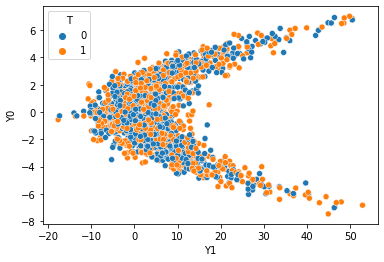

In [4]:
X = np.random.normal(0,1,(2000,5))
Y = np.random.normal(np.sum(X,axis=1),1)
T = np.random.binomial(1,0.5,size=(X.shape[0],))
df = pd.DataFrame(X,columns=['X%d'%(i) for i in range(X.shape[1])])
df['Y0'] = Y
df['Y1'] = Y**2 + np.random.normal(np.mean(X,axis=1),5)
df['T'] = T

sns.scatterplot(y='Y0',x='Y1',hue='T',data=df)

# Example 1 (conVAE class) Learning Y0,Y1 | X0...X4

Initializing and object of class conVAE to learn conditional distribution of Y1,Y0 | X0,..X4. 

Note: In this specific case, both Y1 and Y0 are observed

In [16]:
m = autoencoder.conVAE(df=df,
                       Xnames=['X%d'%(i) for i in range(X.shape[1])],
                       Ynames=['Y0','Y1'],
                       kld_rigidity=0.5)

X_tensor = torch.tensor(df[['X%d'%(i) for i in range(X.shape[1])]].values.astype(float)).float()
Y_tensor = torch.tensor(df[['Y0','Y1']].values.astype(float)).float()
pi = m.forward(Y_tensor)
Y_hat = m.sample(pi, X_tensor)
F.mse_loss(Y_hat,Y_tensor)

tensor(65.4817, grad_fn=<MseLossBackward>)

Initializing the training and fitting the model

In [19]:
trainer = pl.Trainer(max_epochs=100)
trainer.fit(m,m.train_loader,m.val_loader)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 48    
1 | en_mu     | Linear     | 34    
2 | en_logvar | Linear     | 34    
3 | decoder   | Sequential | 128   
4 | decode_Y  | Linear     | 34    
-----------------------------------------
278       Trainable params
0         Non-trainable params
278       Total params
0.001     Total estimated model params size (MB)
/Users/harshparikh/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/Users/harshparikh/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasin

Validation sanity check: 0it [00:00, ?it/s]

/Users/harshparikh/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

Comparing the generated data with the true observed data

Text(0.5, 1.0, 'Observed')

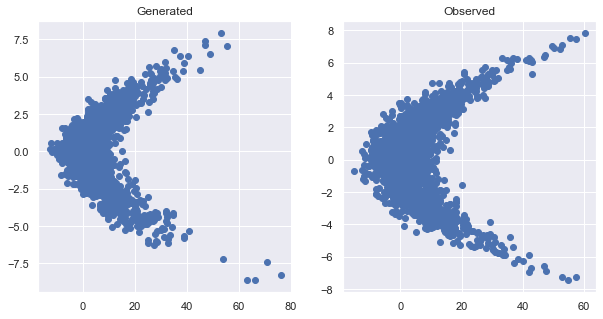

In [20]:
X1 = np.random.normal(0,1,(2000,5))
Y1 = np.random.normal(np.sum(X1,axis=1),1)

df1 = pd.DataFrame(X1,columns=['X%d'%(i) for i in range(X1.shape[1])])
df1['Y0'] = Y1
df1['Y1'] = Y1**2 + np.random.normal(np.mean(X1,axis=1),5)

X_tensor = torch.tensor(df1[['X%d'%(i) for i in range(X1.shape[1])]].values.astype(float)).float()
Y_tensor = torch.tensor(df1[['Y0','Y1']].values.astype(float)).float()
pi = m.forward(Y_tensor)
Y_hat = m.sample(pi, X_tensor)
F.mse_loss(Y_hat,Y_tensor)

sns.set()
fig,ax = plt.subplots(ncols=2,figsize=(10,5))
ax[0].scatter(y=Y_hat[:,0].detach(),x=Y_hat[:,1].detach())
ax[0].set_title('Generated')
ax[1].scatter(y=df['Y0'],x=df['Y1'])
ax[1].set_title('Observed')

# Example 2 (Credence class)

Generating Data

In [5]:
X = np.random.normal(0,1,(2000,5))
Y0 = np.random.normal(np.sum(X,axis=1),1)
T = np.random.binomial(1,0.5,size=(X.shape[0],))
df = pd.DataFrame(X,columns=['X%d'%(i) for i in range(X.shape[1])])
Y1 = Y0**2 + np.random.normal(np.mean(X,axis=1),5)
df['T'] = T
df['Y'] = T*Y1 + (1-T)*Y0

This is a classic causal example.
Importing Credence Package

Initializing credence object

In [6]:
v = credence.Credence(data=df, # dataframe 
                         post_treatment_var=['Y'], # list of post treatment variables
                         treatment_var=['T'], # list of treatment variable(s)
                         categorical_var=['T'], # list of variables which are categorical
                         numerical_var=['X%d'%(i) for i in range(X.shape[1])]+['Y'], # list of variables which are numerical
                     )

Fitting the credence object with observed data

In [11]:
gen = v.fit(effect_rigidity=0,kld_rigidity=1,max_epochs=100)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 32    
1 | en_mu     | Linear     | 34    
2 | en_logvar | Linear     | 34    
3 | decoder   | Sequential | 48    
4 | decode_Y  | Linear     | 17    
-----------------------------------------
165       Trainable params
0         Non-trainable params
165       Total params
0.001     Total estimated model params size (MB)
/Users/harshparikh/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/Users/harshparikh/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasin

Validation sanity check: 0it [00:00, ?it/s]

/Users/harshparikh/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 96    
1 | en_mu     | Linear     | 34    
2 | en_logvar | Linear     | 34    
3 | decoder   | Sequential | 64    
4 | decode_Y  | Linear     | 85    
-----------------------------------------
313       Trainable params
0         Non-trainable params
313       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 32    
1 | en_mu     | Linear     | 34    
2 | en_logvar | Linear     | 34    
3 | decoder   | Sequential | 144   
4 | decode_Y  | Linear     | 34    
-----------------------------------------
278       Trainable params
0         Non-trainable params
278       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Sampling using the learned model

In [12]:
df_gen = v.sample()

<AxesSubplot:xlabel='1', ylabel='0'>

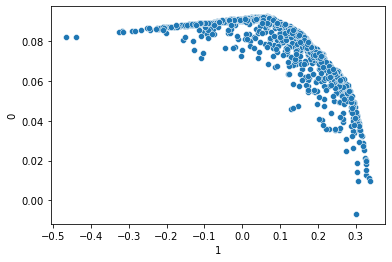

In [14]:
sns.scatterplot(y=0,x=1,data=df_gen)